# Introduction:
- Twitter has become an important communication channel in times of emergency.
- The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

Importing the libraries

In [41]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.naive_bayes import MultinomialNB as mb
from sklearn.linear_model import LogisticRegression

In [3]:
df_train = pd.read_csv('train (1).csv')
df_test = pd.read_csv('test (1).csv')

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [6]:
df_train.shape

(7613, 5)

In [7]:
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [8]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
df_test.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [10]:
df_test.shape

(3263, 4)

In [11]:
df_test.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [12]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

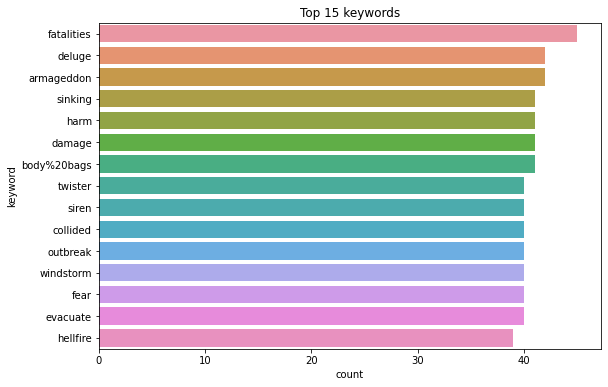

In [15]:
plt.figure(figsize=(9,6))
sns.countplot(y = df_train.keyword, order= df_train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

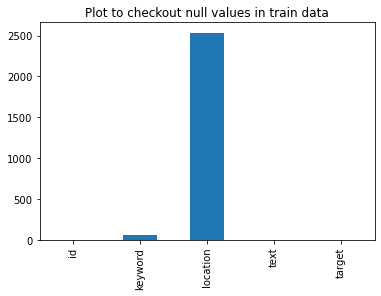

In [16]:
df_train.isna().sum().plot(kind = 'bar')
plt.title('Plot to checkout null values in train data')
plt.show()

In [17]:
df_train = df_train.drop(['location','keyword'],axis=1)
df_test = df_test.drop(['location','keyword'],axis=1)

<AxesSubplot:xlabel='target', ylabel='count'>

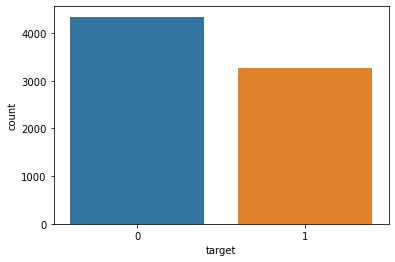

In [18]:
sns.countplot(x = 'target', data = df_train)

In [19]:
d_t = df_train[df_train['target'] == 1]['text']
for i in range(1,5):
    print(d_t[i])

Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [20]:
nd_t = df_train[df_train['target'] != 1]['text']
print(nd_t.head(5))

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object


Text(0.5, 1.0, 'Non Disaster tweets')

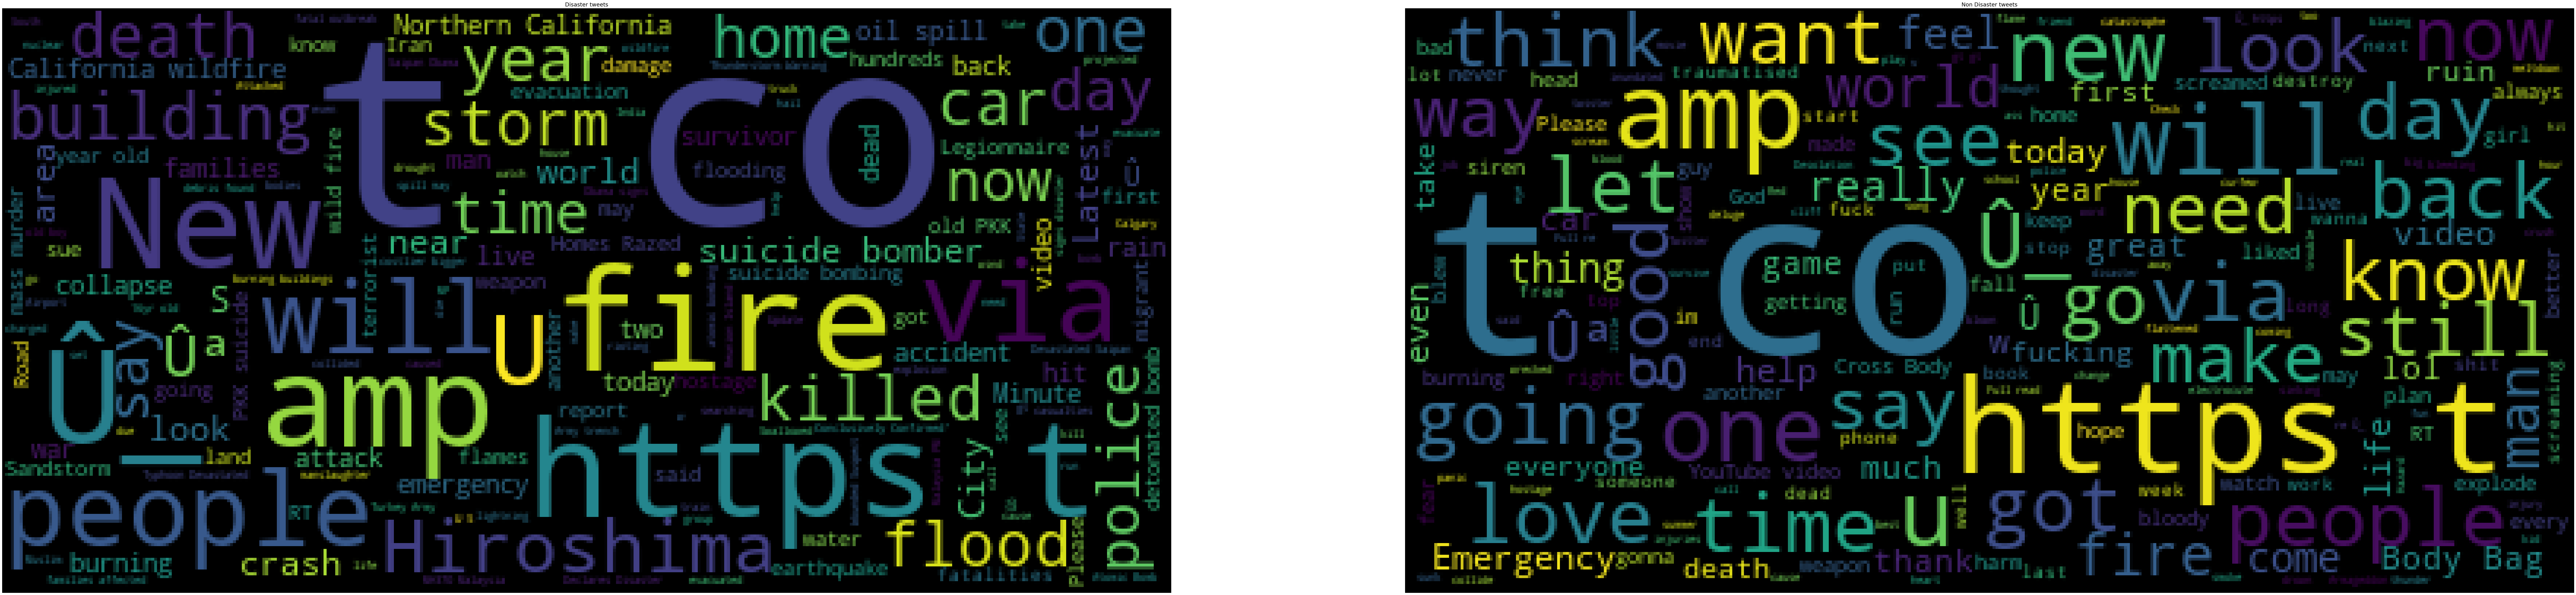

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [150, 50])
wc1 = WordCloud().generate(''.join(d_t))
ax1.imshow(wc1)
ax1.axis('off')
ax1.set_title('Disaster tweets', fontsize = 18)
wc2 = WordCloud().generate(''.join(nd_t))
ax2.imshow(wc2)
ax2.axis('off')
ax2.set_title('Non Disaster tweets', fontsize = 18)

In [24]:
def clean_text(t):
    # Convert to lower
    t = t.lower()
    # remove html tags
    t = re.sub(r'\[.*?\]',' ', t)
    # remove link
    t = re.sub(r'https?://\S+|www\.\S+',' ', t)
    #remove line breaks
    t = re.sub(r'\n',' ',t)
    #Remove trailing spaces, tabs
    t  = re.sub('\s+',' ',t)
    # remove punctuation
#     t = re.sub('[%s]' % re.escape(string.punctuation), t)
    # Remove special characters
    t = re.sub('\w*\d\w*','',t)
    return t
test_str = df_train.loc[417, 'text']
print('Original text: '+test_str+'\n')
print('Original text after cleaning '+clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb

Original text after cleaning arson suspect linked to  fires caught in northern california 


In [25]:
df_train['text'] = df_train['text'].apply(lambda x:clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x:clean_text(x))

## checkout train after cleaning
df_train['text'].head(5)

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    , people receive #wildfires evacuation orders ...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

In [27]:
tokenizer = RegexpTokenizer(r'\w+')
df_train['text'] = df_train['text'].map(tokenizer.tokenize)
df_test['text'] = df_test['text'].map(tokenizer.tokenize)
df_train['text'].head(5)

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [28]:
def remove_stopwords(t):
    words = [w for w in t if w not in stopwords.words('english')]
    return words
df_train['text'] =df_train['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] =df_test['text'].apply(lambda x: remove_stopwords(x))
df_train['text'].head(5)

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [29]:
def lem_words(t):
    l = WordNetLemmatizer()
    return [l.lemmatize(w) for w in t]
df_train['text'] =df_train['text'].apply(lambda x: lem_words(x))
df_test['text'] =df_test['text'].apply(lambda x: lem_words(x))
df_train['text'].head(5)

0    [deed, reason, earthquake, may, allah, forgive...
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3    [people, receive, wildfire, evacuation, order,...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [30]:
def combine_txt(t):
    c  = ' '.join(t)
    return c
df_train['text'] =df_train['text'].apply(lambda x: combine_txt(x))
df_test['text'] =df_test['text'].apply(lambda x: combine_txt(x))
df_train['text'].head(5)

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

In [32]:
c = CountVectorizer()
tr_v = c.fit_transform(df_train['text'])
te_v = c.fit_transform(df_test['text'])
print(tr_v[0].todense())

[[0 0 0 ... 0 0 0]]


In [34]:
tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1,2))
tr_t = tfidf.fit_transform(df_train['text'])
te_t = tfidf.transform(df_test['text'])

In [39]:
lg = LogisticRegression()
vector_score = cross_val_score(lg, tr_v, df_train['target'],
                              cv=5, scoring='f1')
print(vector_score)
tfidf_score = cross_val_score(lg, tr_t, df_train['target'],
                              cv=5, scoring='f1')
print(tfidf_score)

[0.62655205 0.52433817 0.6035313  0.52847806 0.7057903 ]
[0.5623069  0.5013876  0.56862745 0.42629905 0.67244367]


In [40]:
m = mb()
vector_score = cross_val_score(m, tr_v, df_train['target'],
                              cv=5, scoring='f1')
print(vector_score)
tfidf_score = cross_val_score(m, tr_t, df_train['target'],
                              cv=5, scoring='f1')
print(tfidf_score)

[0.64279902 0.61724875 0.67412587 0.6401249  0.73271277]
[0.57894737 0.58523726 0.62139219 0.59797608 0.74842767]


# Conclusion:
Naive bayes has the highest vector, hence we choose that for building the project